In [ ]:
!pip install keras

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from PIL import Image

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


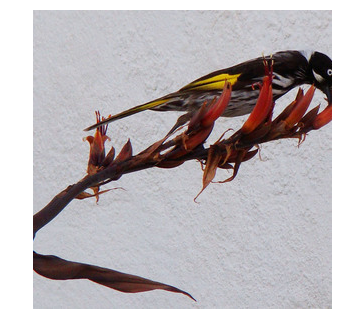

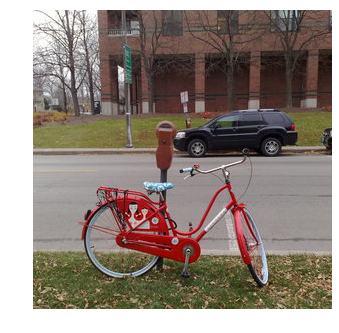

In [2]:
from keras.preprocessing import image
import os.path as osp
import os
import seaborn as sns

DATASET_ROOT = '/root/cvd_open_images/easy_images'

image_paths_bicycle = os.listdir(osp.join(DATASET_ROOT, 'bicycle'))
image_paths_bicycle = [os.path.join(DATASET_ROOT,'bicycle', path) for path in image_paths_bicycle]

image_paths_bird = os.listdir(osp.join(DATASET_ROOT, 'bird'))
image_paths_bird = [os.path.join(DATASET_ROOT,'bird', path) for path in image_paths_bird]

# Truncate eval dataset
image_paths_bird = image_paths_bird[:500]
image_paths_bicycle = image_paths_bicycle[:500]

def show_image(im):
    plt.axis('off')
    im = image.load_img(im, target_size=(299, 299))
    plt.imshow(im)
    plt.show()
    
show_image(image_paths_bird[0])
show_image(image_paths_bicycle[0])

In [3]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
import numpy as np

base_model = InceptionResNetV2(weights='imagenet', include_top=False)

# add a global spatial average pooling layer and single layer perceptron
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='categorical_crossentropy')

NameError: name 'GlobalAveragePooling2D' is not defined

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)

In [ ]:
img = image.load_img(image_paths_bird[0], target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

plt.imshow(x[0])
plt.show()

In [ ]:
print(np.max(x), np.min(x), np.mean(x))

In [ ]:
# Collect all the logits and images in arrays
import os
image_paths = image_paths_bicycle + image_paths_bird

# bird is one
y_true = np.concatenate([np.zeros((len(image_paths_bicycle),)), np.ones((len(image_paths_bird),))])

In [ ]:
batch_size = 32
from tqdm import tqdm as tqdm

def to_batches(iterable, batch_size):
    return [iterable[i * batch_size:(i + 1) * batch_size]
          for i in range((len(iterable) + batch_size - 1) // batch_size)]

image_patch_batches = to_batches(image_paths, batch_size)

preds = []
for batch in tqdm(image_patch_batches):
    x_batch = []
    for img_path in batch:
        img = image.load_img(img_path, target_size=(299, 299))
        x_batch.append(image.img_to_array(img))

    x_batch = np.stack(x_batch)
    x_batch = preprocess_input(x_batch)
    preds.append(model.predict(x_batch))
    
preds = np.concatenate(preds)
        

In [ ]:
len(preds)

In [ ]:
# TODO: See if more classes helps here
BIRD_CLASSES = list(range(80,100+1))
BICYCLE_CLASSES = [671, 444]

print(BIRD_CLASSES)

bird_preds = np.mean(preds[:, BIRD_CLASSES], axis=1)
bicycle_preds = np.sum(preds[:, BICYCLE_CLASSES], axis=1)


In [ ]:
is_correct = (bird_preds > bicycle_preds) == y_true.astype(np.bool)
print("accuracy: ")
np.mean(is_correct)

# Previous: 0.964517625231911
# use my graphing code

In [ ]:

labels = bird_preds > bicycle_preds
confidences = np.abs(bird_preds - bicycle_preds)


def plot_confident_error_rate(labels, confidences, y_true, title="Risk vs Coverage"):
    sorted_confidences = list(sorted(confidences, reverse=True))

    coverages = np.linspace(0.01, .99, 99)
    cov_to_confident_error_idxs = []

    for coverage in coverages:    
        threshold = sorted_confidences[int(coverage * len(labels))]
        confident_mask = confidences >= threshold
        confident_error_mask = (y_true != labels) * confident_mask
        confident_error_idx = confident_error_mask.nonzero()[0]
        
        cov_to_confident_error_idxs.append(confident_error_idx)
        
    plt.plot(coverages, [float(len(idxs)) / len(labels) for idxs in cov_to_confident_error_idxs])
    plt.title(title)
    plt.ylabel("Risk \n (error rate on covered data)")
    plt.xlabel("Coverage \n (fraction of points not abstained on)")
    
    plt.legend(["Pretrained Inception Resnet w/o finetuning"])
    plt.show()
    return cov_to_confident_error_idxs
    
cov_to_confident_error_idxs = plot_confident_error_rate(
    labels, confidences, y_true, title="Risk vs Coverage for Clean Two-Class Unambiguous ImageNet \n (Bird vs Bicycle)")

In [ ]:
print(len(cov_to_confident_error_idxs))

In [ ]:
incorrect_idxs = cov_to_confident_error_idxs[90]

for idx in incorrect_idxs:
    print("True: %s" %('bird' if y_true[idx] else 'bicycle'))
    print("Pred: %s" %('bird' if labels[idx] else 'bicycle'))
#     print(np.argmax(preds[idx, BOAT_CLASSES]))
    show_image(image_paths[idx])